# 1 Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1.1 Default Plots Configs

In [2]:
# Matplotlib
%matplotlib inline
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (15,4)
plt.style.use('fivethirtyeight')
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams["figure.facecolor"] = 'f2f2f2'
plt.rcParams["axes.facecolor"] = 'f2f2f2'
plt.rcParams["savefig.facecolor"] = 'f2f2f2'

# 2. Data

## 2.1 Importing

In [3]:
market = pd.read_csv('marketData.csv', parse_dates = [0], index_col = 'Date')
sentiment = pd.read_csv('sentimentData.csv', parse_dates = [0], delimiter = ',', low_memory = False, usecols = np.arange(0,6))

## 2.2 Wrangling

In [4]:
# Removimg time and renaming the column 'TIMESTAMP' to 'Date'
sentiment.TIMESTAMP = sentiment.TIMESTAMP.dt.date
sentiment.rename(columns = {'TIMESTAMP' : 'Date'}, inplace = True)

# Removing rows where RELEVANCE values are out of the range
sentiment = sentiment.query('RELEVANCE >= -1 & RELEVANCE <= 1')

# Removing rows where SENT probabilities values are out of the range
sentiment = sentiment.query('SENT_POS + SENT_NEUT + SENT_NEG < 1.01 & SENT_POS + SENT_NEUT + SENT_NEG > 0.99')

## 2.3 Preprocessing

### 2.3.1 Calculating the Score

#### 2.3.1.1 Score Base Formula

In [5]:
# Formula
pos_weight = 1
neut_weight = 0
neg_weight = -1
relevance_coef = 1

sentiment_scores = pd.Series(dtype = 'float64')

for index, row in sentiment.iterrows():
    if(row['SENT_POS'] >= 0.7):
        sentiment_scores = sentiment_scores.append(pd.Series(relevance_coef * row['RELEVANCE'] * (pos_weight * row['SENT_POS'])))
    elif (row['SENT_NEG'] >= 0.7):
        sentiment_scores = sentiment_scores.append(pd.Series(relevance_coef * row['RELEVANCE'] * (neg_weight * row['SENT_NEG'])))
    else:
        sentiment_scores = sentiment_scores.append(pd.Series(0))

# Formatting
sentiment_scores = sentiment_scores.reset_index().drop(['index'], axis = 1)
sentiment_scores.rename(columns = {0 : 'Score'}, inplace = True)
sentiment = sentiment.merge(sentiment_scores, left_index = True, right_index = True)

# Aggregating Scores by Date and Stock
sentiment = sentiment.groupby(['Date', 'STOCK']).mean()

#### 2.3.1.2 Score SMA and Pre Formatting Sentiment Table

In [6]:
# Dropping useless columns
sentiment_score = sentiment.drop(['RELEVANCE', 'SENT_POS', 'SENT_NEUT', 'SENT_NEG'], axis = 1)
sentiment_score = sentiment_score.reset_index(1)

# Pivoting
sentiment_score = sentiment_score.pivot(columns = 'STOCK', values = 'Score')

# Filling the missing values 
sentiment_score = sentiment_score.fillna(method = 'ffill').fillna(method = 'bfill')

# Calculating SP500 Score
sentiment_score['SP500'] = sentiment_score.mean(axis=1)

# Calculating SMA
days = 30
sentiment_score_sma = sentiment_score.rolling(window = days).mean()

### 2.3.2 Joining Sentiment and Market tables

#### 2.3.2.1 Formatting Sentiment table

In [7]:
# Unpivoting
sentiment_formated = sentiment_score_sma.melt(ignore_index = False, value_name = 'Value')
sentiment_formated['ValueType'] = 'Sentiment Score'

# Dropping missing values
sentiment_formated.dropna(inplace = True)

#### 2.3.2.2 Formatting Market Table

In [8]:
# Unpivoting
market_formated = market.reset_index(0)
market_formated = market_formated.melt(id_vars = ['Date'], var_name = 'STOCK', value_name = 'Value') 
market_formated['ValueType'] = 'Price'

market_formated = market_formated.set_index('Date')

#### 2.3.2.3 Union

In [9]:
# Appending
score_and_price = market_formated.append(sentiment_formated)
score_and_price = score_and_price.reset_index()

# Dropping missing values
score_and_price.dropna(inplace = True)

# Filtering values for SP500
price_sp = score_and_price.query("STOCK == 'SP500' & ValueType == 'Price'")
score_sp = score_and_price.query("STOCK == 'SP500' & ValueType == 'Sentiment Score'")

# 3. Charts

## 3.1 Stocks & Sentiment Scores

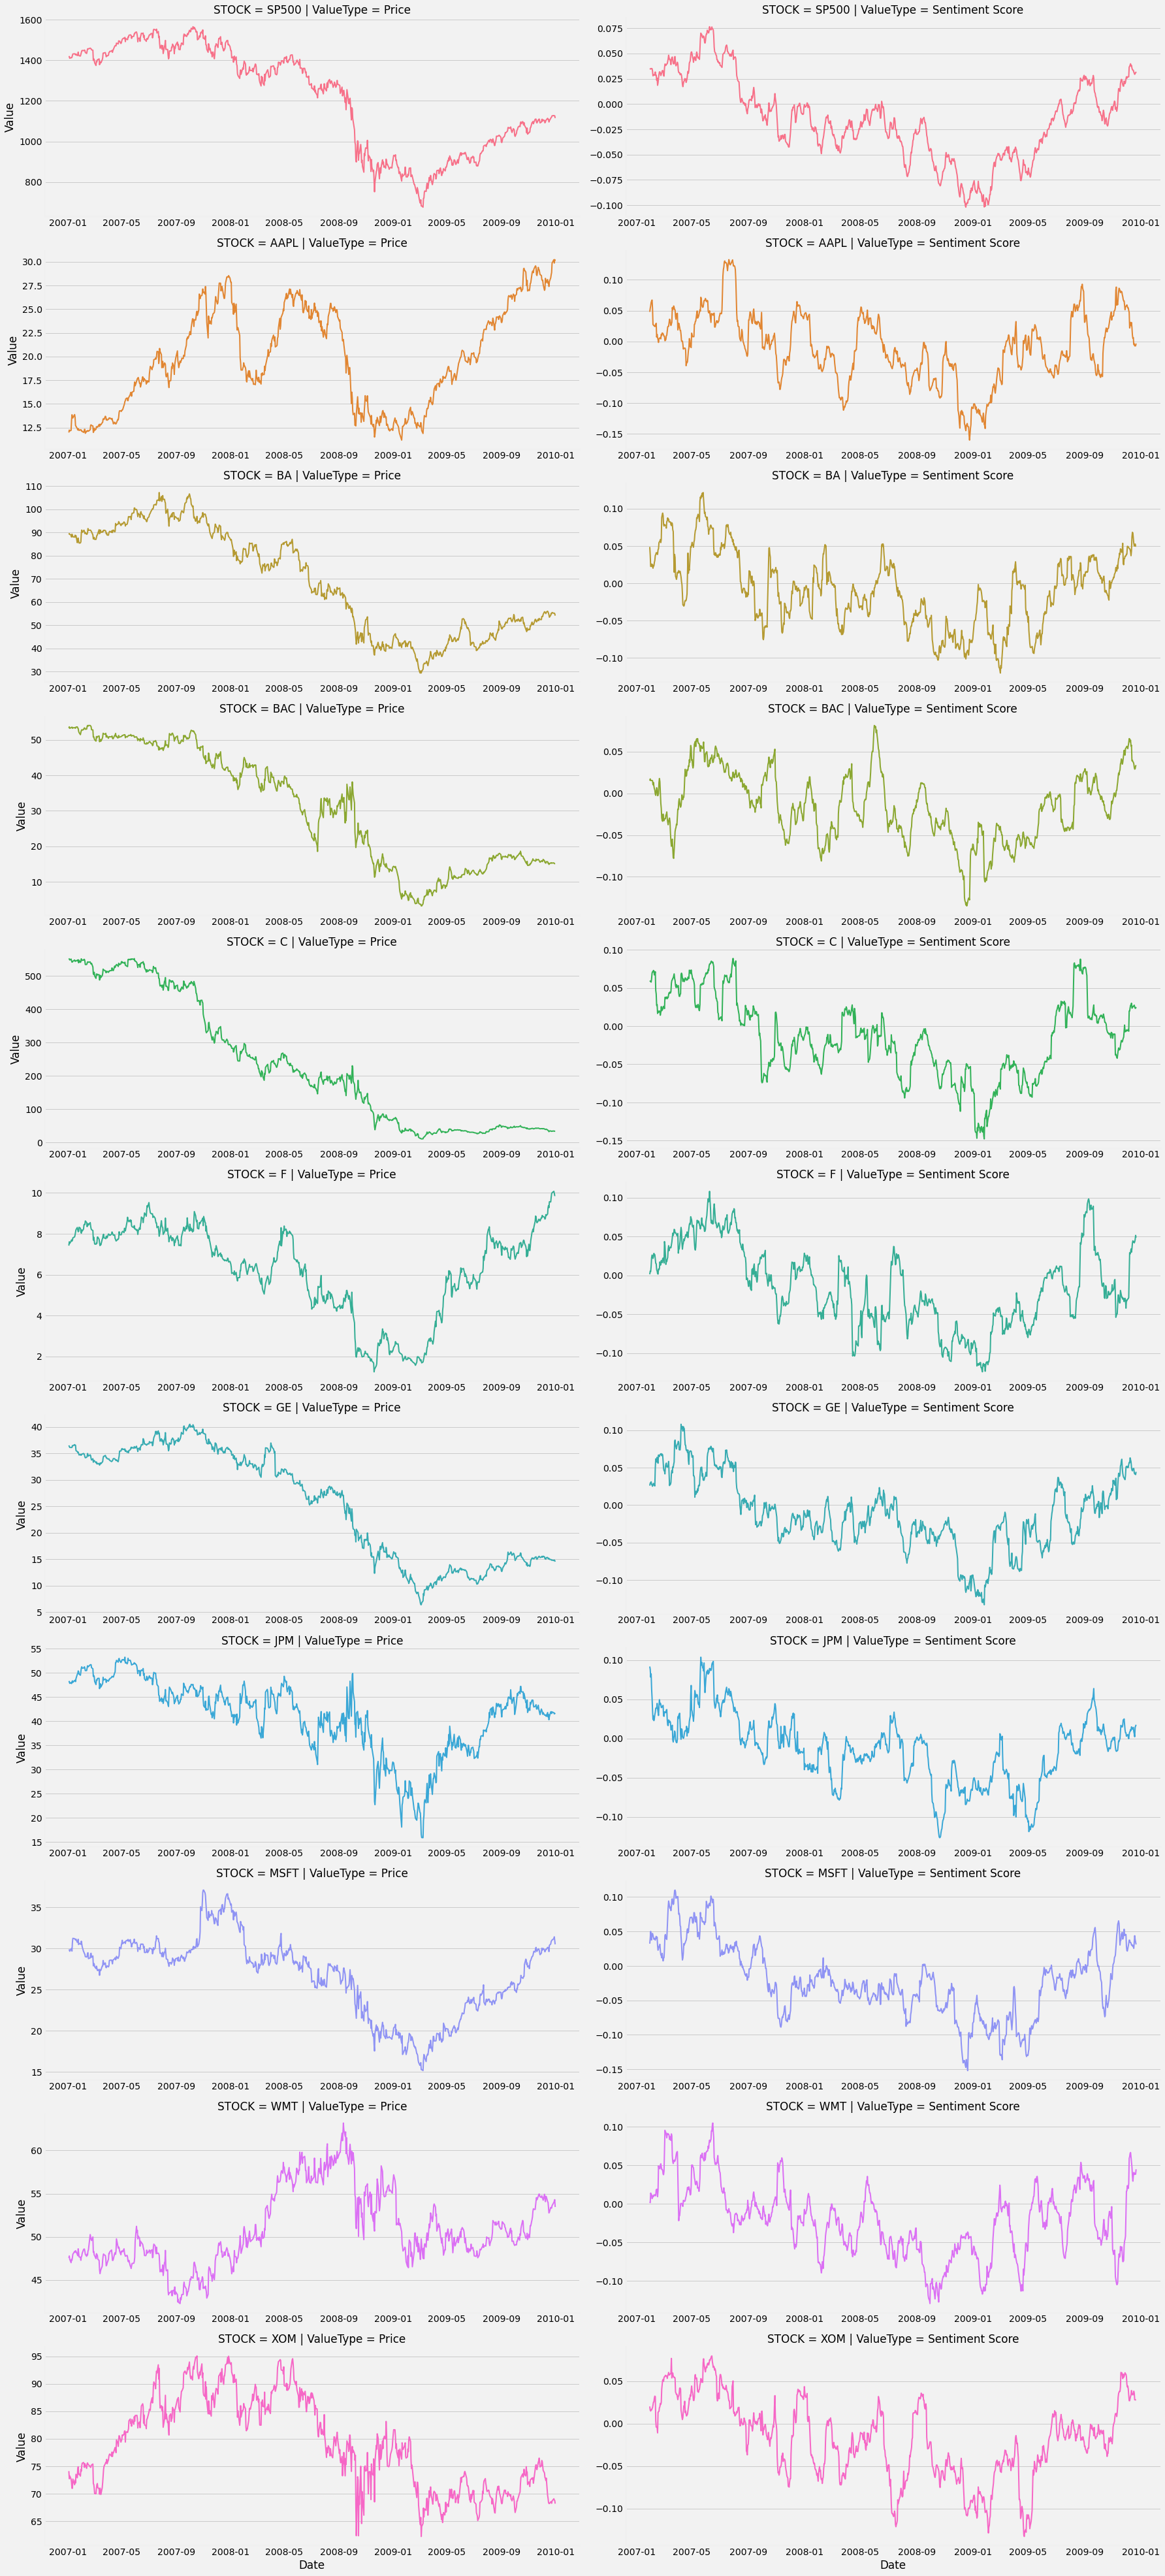

In [10]:
fig = sns.FacetGrid(score_and_price, col = 'ValueType', row  = 'STOCK', hue = 'STOCK', sharex = False, 
                    sharey = False, height = 5, aspect = 2.5)

fig.map(sns.lineplot, 'Date', 'Value', lw = 2)

## 3.2 SP500 & Sentiment Scores

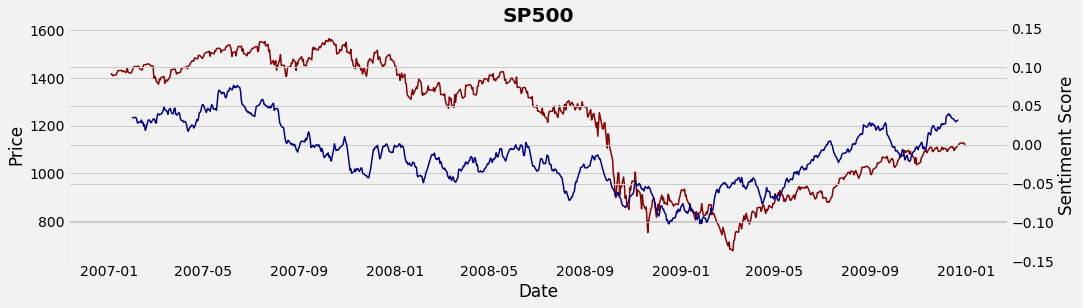

In [11]:
# Figure
fig, ax1 = plt.subplots()

# Axes 1
ax1.plot(price_sp.Date, price_sp.Value, color = "darkred", lw = 1.5)
ax1.set(xlabel = 'Date', ylabel = 'Price', title = 'SP500')
plt.setp(ax1.title, fontweight = 'bold')

# Axes 2
ax2 = ax1.twinx()
ax2.plot(score_sp.Date, score_sp.Value, color = "darkblue", lw = 1.5)
ax2.set(ylabel = 'Sentiment Score')
ax2.set_ylim(-0.15, 0.15)

# Plotting
plt.show()

# 4 Evaluating Sentiment Score Formula

## 4.1 Wrangling Data

In [12]:
# Formatting Sentiment table
sentiment_reg_format = sentiment.drop(['RELEVANCE', 'SENT_POS', 'SENT_NEUT', 'SENT_NEG'], axis = 1)
sentiment_reg_format = sentiment_reg_format.groupby(['Date']).mean()

# Formatting Market table
market_reg_format = market_formated.query("STOCK == 'SP500'")
market_reg_format = market_reg_format.drop(['STOCK', 'ValueType'], axis = 1)

# Joining tables
sentiment_and_price = market_reg_format.join(sentiment_reg_format)
sentiment_and_price = sentiment_and_price.rename(columns = {'Value' : 'PRICE'})

# Formatting final table
sentiment_and_price = sentiment_and_price.reset_index(0, drop = True)
price_column = sentiment_and_price.pop('PRICE')
sentiment_and_price.insert(1, 'PRICE', price_column)

## 4.2 Pearson R 

In [13]:
sentiment_and_price.corr()

,Score,PRICE
Score,1.000000,0.356294
PRICE,0.356294,1.000000
